In [26]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [27]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [28]:
import zipfile
zip_ref = zipfile.ZipFile('/content/PlantVillage.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [29]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [30]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


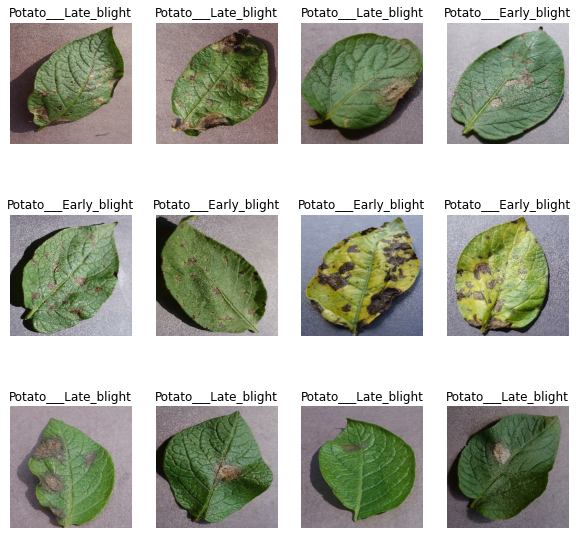

In [31]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())
  for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [32]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [33]:
train_ds = dataset.take(54)
len(train_ds)

54

In [34]:
test_size=0.2
len(dataset)*test_size

13.600000000000001

In [35]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [36]:
test_ds = test_ds.take(6)
len(test_ds)

6

In [37]:
val_ds = test_ds.skip(6)
len(val_ds)

0

In [38]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [39]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [40]:
len(train_ds)

54

In [41]:
len(test_ds)

8

In [42]:
len(val_ds)

6

In [43]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [44]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [45]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [46]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [47]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [48]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [49]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [50]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 20s 316ms/step - loss: 0.9110 - accuracy: 0.4763 - val_loss: 0.9216 - val_accuracy: 0.4792
Epoch 2/50
54/54 [==============================] - 15s 280ms/step - loss: 0.7133 - accuracy: 0.6377 - val_loss: 0.7687 - val_accuracy: 0.6302
Epoch 3/50
54/54 [==============================] - 17s 309ms/step - loss: 0.5746 - accuracy: 0.7378 - val_loss: 0.4613 - val_accuracy: 0.8073
Epoch 4/50
54/54 [==============================] - 15s 280ms/step - loss: 0.4373 - accuracy: 0.8137 - val_loss: 0.2974 - val_accuracy: 0.8750
Epoch 5/50
54/54 [==============================] - 15s 275ms/step - loss: 0.2962 - accuracy: 0.8837 - val_loss: 0.2395 - val_accuracy: 0.8906
Epoch 6/50
54/54 [==============================] - 15s 275ms/step - loss: 0.2052 - accuracy: 0.9172 - val_loss: 0.1145 - val_accuracy: 0.9427
Epoch 7/50
54/54 [==============================] - 15s 279ms/step - loss: 0.2093 - accuracy: 0.9155 - val_loss: 0.2133 - val_accuracy: 0.9115

In [51]:
len(test_ds)

8

In [52]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 33ms/step - loss: 0.0520 - accuracy: 0.9688


In [53]:
history.history

{'loss': [0.9109926819801331,
  0.7133010625839233,
  0.5745784044265747,
  0.4372958838939667,
  0.29616761207580566,
  0.20520943403244019,
  0.209326833486557,
  0.22584213316440582,
  0.13192933797836304,
  0.11164829134941101,
  0.10353709757328033,
  0.07762622833251953,
  0.08511184900999069,
  0.09228252619504929,
  0.10031772404909134,
  0.11166399717330933,
  0.0724431648850441,
  0.07609719783067703,
  0.03727186471223831,
  0.11584305763244629,
  0.09309244900941849,
  0.06528950482606888,
  0.06842885166406631,
  0.05948658287525177,
  0.06249123066663742,
  0.07219124585390091,
  0.0542212575674057,
  0.0731813982129097,
  0.0411420576274395,
  0.03309990465641022,
  0.04321787878870964,
  0.05878046527504921,
  0.033757999539375305,
  0.040634386241436005,
  0.05364768207073212,
  0.02814664877951145,
  0.024594688788056374,
  0.032936953008174896,
  0.04916241019964218,
  0.02723516710102558,
  0.03703451156616211,
  0.027950430288910866,
  0.04959345608949661,
  0.0402

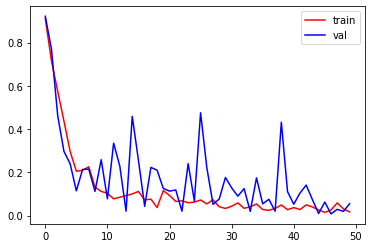

In [57]:
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='val')
plt.legend()

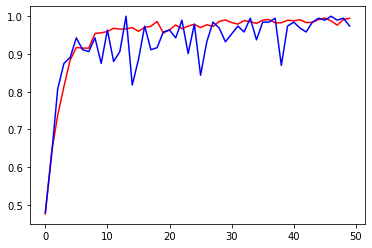

In [58]:
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='val')

first image to predict
actual label: Potato___healthy
predicted label: Potato___healthy


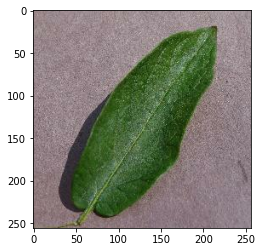

In [75]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [79]:
model_version = 1
model.save(f"classifier/{model_version}")

In [81]:
!zip -r /content/classifier.zip /content/classifier/ 

  adding: content/classifier/ (stored 0%)
  adding: content/classifier/1/ (stored 0%)
  adding: content/classifier/1/variables/ (stored 0%)
  adding: content/classifier/1/variables/variables.index (deflated 72%)
  adding: content/classifier/1/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: content/classifier/1/keras_metadata.pb (deflated 94%)
  adding: content/classifier/1/assets/ (stored 0%)
  adding: content/classifier/1/saved_model.pb (deflated 89%)
